# SVI & COVID - DALLAS

## Summary

The CDC's social vulnerability index (SVI) is a scale that predicts the vulnerability of a population in the event of an emergency or natural disaster. COVID is the first global pandemic since the development of this measure. We will evaluate the association between SVI score and COVID case count in Dallas, Texas. Features from this measure will be incorporated into a predictive model that can be used to guide recovery resource prioritization.



**Goals**      
1. Evaluate association between SVI score and COVID case count in Dallas, TX     
2. Build a model based SVI score component features that can predict COVID cases by census tract within Dallas, TX
4. Is there a difference between San Antonio and Dallas results?


## Imports


In [1]:
import pandas as pd
import seaborn as sns
import wrangle
import explore
import model_MAE

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression, SelectKBest, RFE 
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from math import sqrt
from scipy import stats

# Acquire & Prepare


In [2]:
df, train_exp, X_train_scaled, y_train, X_test_scaled, y_test = wrangle.wrangle_dallas_data()

Acquire: compiling raw data files...
Acquire: Completed!
Prepare: preparing data files...
Prepare: Completed!
(246, 25) (62, 25)


# Explore

Exploration focuses on answering questions regarding the relationship between the CDC's range category SVI score and cases of COVID-19 per 100k.

- Visualize cases per 100K by binned SVI value
    - Appear to be distinct
    - Will conduct parametric ANOCA (Kruskal) test to confirm
- Verify raw SVI score relationship to cases per 100K
    - will conduct Pearson's R correlation test
- Explore distribution of casses per 100K with SVI score
- Explore distribution of flags by SVI score


## Hypothesis Testing

### Question One: Is there a correlation between the CDC's Range Category SVI Score and COVID-19 Infection Cases per 100k Individuals?

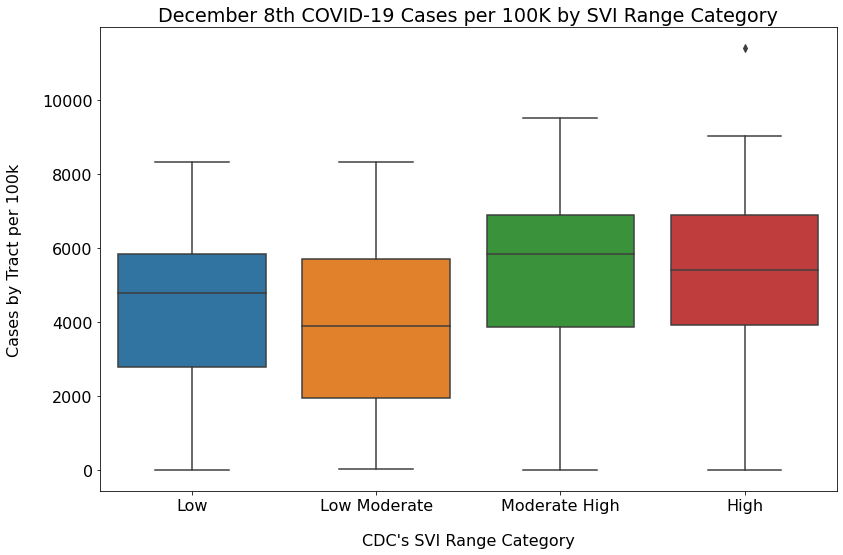

In [3]:
explore.sns_boxplot(train_exp)

**Takeaway:**
`There appears to be a correlation between COVID-19 Count and SVI Category. Next step is Hypothesis testing between categories to validate statistical significance`

In [4]:
# Mean COVID-19 Count By CDC's SVI Category
All = round(train_exp.tract_cases_per_100k.mean(),5)
low = round((train_exp[train_exp.bin_svi == 'Low']).tract_cases_per_100k.mean(),5)
low_mod = round((train_exp[train_exp.bin_svi == 'Low Moderate']).tract_cases_per_100k.mean(),6)
mod_high = round((train_exp[train_exp.bin_svi == 'Moderate High']).tract_cases_per_100k.mean(),6)
high = round((train_exp[train_exp.bin_svi== 'High']).tract_cases_per_100k.mean(),6)

print(f'The average number of cases per 100k for all CDC SVI Range Categories is {All}') 
print(f'The average number of cases per 100k for CDC SVI Range Category (low) is {low}')
print(f'The average number of cases per 100k for CDC SVI Range Category (low_mod) is {low_mod}')
print(f'The average number of cases per 100k for CDC SVI Range Category (mod_high) is {mod_high}')
print(f'The average number of cases per 100k for CDC SVI Range Category (high) is {high}')

The average number of cases per 100k for all CDC SVI Range Categories is 4849.86647
The average number of cases per 100k for CDC SVI Range Category (low) is 4381.45776
The average number of cases per 100k for CDC SVI Range Category (low_mod) is 3874.868917
The average number of cases per 100k for CDC SVI Range Category (mod_high) is 5289.058653
The average number of cases per 100k for CDC SVI Range Category (high) is 5343.016472


In [5]:
low = (train_exp[train_exp.bin_svi == 'Low']).tract_cases_per_100k
low_mod = (train_exp[train_exp.bin_svi == 'Low Moderate']).tract_cases_per_100k
mod_high = (train_exp[train_exp.bin_svi == 'Moderate High']).tract_cases_per_100k
high = (train_exp[train_exp.bin_svi== 'High']).tract_cases_per_100k
alpha = 0.01
null = "Average number of COVID-19 cases per 100k is the same across all CDC SVI Range Categories "
alternate = "Average number of COVID-19 cases per 100k is significantly different across all CDC SVI Range Categories "
explore.kruskal_test(low, low_mod, mod_high, high, null, alternate, alpha)

f= 17.37919795944776
p= 0.0005905152957812457


We reject the null that: 
 Average number of COVID-19 cases per 100k is the same across all CDC SVI Range Categories 


We move forward with the alternative hypothesis that: 
 Average number of COVID-19 cases per 100k is significantly different across all CDC SVI Range Categories 


**Takeaway:**
`We can state with 99% certainty that there is a statistically significant difference between all of the CDC SVI Range Categories`

### Question Two: Is there a correlation between raw_svi and cases per 100k?

In [6]:
raw_svi = train_exp.raw_svi
cases_per_100k = train_exp.tract_cases_per_100k
alpha = 0.01
null = "There is no statistically significant difference betweeen raw_svi and cases per 100K "
alternate = "There is a statistically significant difference betweeen raw_svi and cases per 100K"
explore.pearson(raw_svi, cases_per_100k, null, alternate, alpha)

r= 0.19395225483933634
p= 0.0022461351772073666


We reject the null that: 
 There is no statistically significant difference betweeen raw_svi and cases per 100K 


We move forward with the alternative hypothesis that: 
 There is a statistically significant difference betweeen raw_svi and cases per 100K


**Takeaway:**
`We can state with 99% certainty that there is not a statistically significant difference between the Social Vulnerability Index and Census Tract cases per 100,000 people.`

## Distribution Exploration

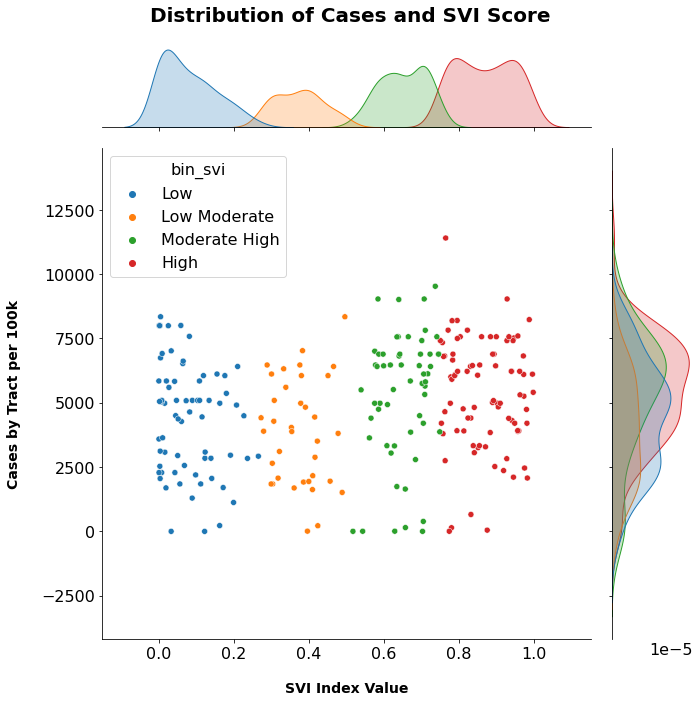

In [7]:
explore.joint_plot_index('raw_svi','tract_cases_per_100k', train_exp, 'bin_svi')

In [8]:
train_exp

,tract,raw_svi,f_pov_soci,f_unemp_soci,f_pci_soci,f_nohsdp_soci,f_soci_total,f_age65_comp,f_age17_comp,f_disabl_comp,...,f_mobile_trans,f_crowd_trans,f_noveh_trans,f_groupq_trans,f_trans_total,all_flags_total,zip,tract_cases_per_100k,bin_svi,rank_svi
236,48113013616,0.0891,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,75240.0,1295.217285,Low,4
77,48113006402,0.8041,0,0,0,1,1,0,0,0,...,0,1,0,0,1,3,75211.0,7567.000000,High,1
193,48113012000,0.8900,0,0,1,1,2,0,1,0,...,0,0,0,0,0,6,75217.0,5012.209514,High,1
177,48113011001,0.6402,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,75224.0,9014.689022,Moderate High,2
7,48113000406,0.4159,0,0,0,0,0,0,0,0,...,0,1,0,0,2,3,75209.0,4445.372230,Low Moderate,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,48113013804,0.3548,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,75234.0,3883.459961,Low Moderate,3
102,48113007819,0.5758,0,0,0,0,0,0,0,0,...,0,0,1,0,2,2,75231.0,4982.000000,Moderate High,2
40,48113002500,0.9334,1,0,1,1,3,0,0,0,...,0,1,1,0,2,7,75223.0,4394.880971,High,1
210,48113012702,0.6177,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,75228.0,6469.000000,Moderate High,2


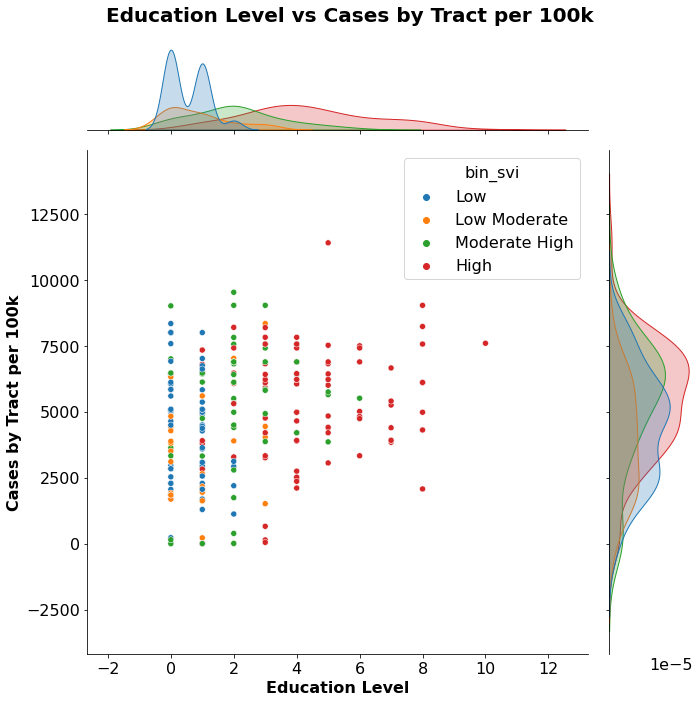

In [9]:
explore.my_plotter(train_exp, 'all_flags_total', "Education Level", 'tract_cases_per_100k', "Cases by Tract per 100k")
plt.show()

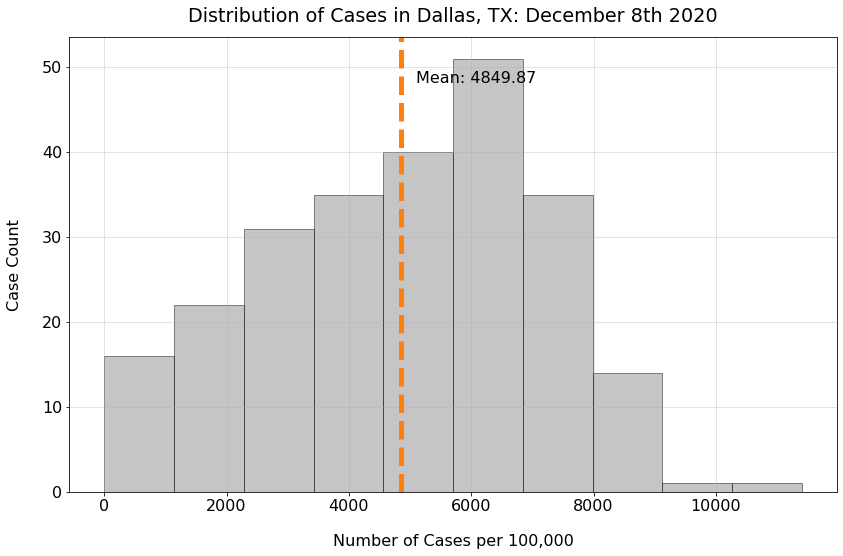

In [10]:
# re-run explore.py to get this to update. Works in my notebook.

explore.hist_case_title(train_exp.tract_cases_per_100k, "Distribution of Cases in Dallas, TX: December 8th 2020")

# Model the Data

- Baseline for modeling determined by plotting the histogram distribution of COVID-19 cases per 100k.
- The skew observed in the distribution led us to use the median for this value instead of the mean??
- Used cross validation due to limited size of dataset. Size of dataset limited by Dallas number of census tracts.
- Three of the 4 models used all of the features in the dataset, one model used only the top4 features identified by RFE.
- Linear Regression, LassoLars, and 2 degree polynomial features used all features and a 2nd version of 2 degree polynomial was run with just the top4 features.
- Of these the LassoLars had the least MAE (mean absolute error) and was run on out of sample data (test).
- This model had nearly identical MAE when run on out of sample data, only a 0.7 difference in MAE.
- Overall this is a 25% improvement from mean baseline MAE.

## Create Baseline

In [11]:
# What is the mean vs median of the target variable?
y_train.tract_cases_per_100k.mean(), y_train.tract_cases_per_100k.median()

(4849.866470319118, 5023.511679404)

In [12]:
# calculate the mean absolute error (MAE) of the baseline using mean
mean_baseMAE, basepred1 = model_MAE.get_baseline_mean(y_train)

Baseline MAE: 1861.849146190839


## Feature Ranking

- Use recursive feature elimination to evaluate features for modeling

In [13]:
rankdf = model_MAE.feature_ranking(X_train_scaled, y_train)
rankdf

,features
rank,
1,f_status_total_scaled
2,raw_svi
3,rank_svi_scaled
4,f_nohsdp_soci
5,f_age65_comp
6,f_noveh_trans
7,f_munit_trans
8,f_disabl_comp
9,all_flags_total_scaled


## Feature Selection

In [14]:
# only raw svi score
X_raw_svi = X_train_scaled[['raw_svi']]
# binned svi score by CDC range category = 1st ranked
X_rank_svi_only = X_train_scaled[['rank_svi_scaled']]
# top 4 ranked features
X_top4 = X_train_scaled[['f_status_total_scaled', 'raw_svi', 'rank_svi_scaled', 'f_nohsdp_soci']]
# only the summary of the flags = 19th ranked
X_all_flags_only = X_train_scaled[['all_flags_total_scaled']]
# only summary flags, should be the same as all flags total? = 5th, 12th, 15th, 21st
X_summary_flags = X_train_scaled[['f_comp_total_scaled', 'f_soci_total_scaled', 'f_status_total_scaled', 'f_trans_total_scaled']]
# all individual flags
X_not_summary_flags = X_train_scaled[['f_nohsdp_soci', 'f_minrty_status', 'f_groupq_trans', 'f_unemp_soci', 
                                     'f_disabl_comp', 'f_noveh_trans', 'f_mobile_trans', 'f_age65_comp', 
                                     'f_age17_comp', 'f_pov_soci', 'f_limeng_status', 'f_crowd_trans', 
                                      'f_pci_soci', 'f_sngpnt_comp', 'f_munit_trans']]

## Build Models

- due to limited size of dataset (limited by number of zip codes in Dallas county) cross validation will be used for the train and validate stages of modeling
- regression models will be used because the target variable is continuous
- models to try: linear regression, LassoLars, Tweedie Regressor Random Forest Regressor, Support Vector Regressor (SVR)

In [15]:
# Linear Regression
# create variables for loop
df2test = [X_rank_svi_only, X_top4, X_all_flags_only, X_summary_flags, X_not_summary_flags, X_train_scaled, X_raw_svi]
target = y_train

# Linear Regression Models
cvlm_MAE_list = []
for df in df2test:
    cvlm_MAE = model_MAE.cvLinearReg(df, target) 
    cvlm_MAE_list.append(cvlm_MAE)

MAE: 1852.613 (1250.626)
MAE: 1769.445 (1228.755)
MAE: 1859.461 (1222.728)
MAE: 1796.553 (1247.350)
MAE: 1807.164 (1297.909)
MAE: 1821.096 (1303.745)
MAE: 1854.677 (1259.087)


In [16]:
# Lasso Lars
# create variables for loop
df2test = [X_rank_svi_only, X_top4, X_all_flags_only, X_summary_flags, X_not_summary_flags, X_train_scaled, X_raw_svi]
target = y_train

# LassoLars Models
cvll_MAE_list = []
for df in df2test:
    cvll_MAE = model_MAE.cvLassoLars(df, target, 1) 
    cvll_MAE_list.append(cvll_MAE)

MAE: 1852.224 (1251.292)
MAE: 1775.747 (1228.092)
MAE: 1858.492 (1224.286)
MAE: 1798.631 (1244.787)
MAE: 1787.486 (1279.463)
MAE: 1798.290 (1286.970)
MAE: 1854.099 (1260.013)


In [17]:
# Random Forest, send in x scaled, y train, and # estimators
df2test = [X_rank_svi_only, X_top4, X_all_flags_only, X_summary_flags, X_not_summary_flags, X_train_scaled, X_raw_svi]
target = y_train

# Random Forest Models
cvrf_MAE_list = []
for df in df2test:
    cvrf_MAE = model_MAE.cvRandomForest(df, target, 4) 
    cvrf_MAE_list.append(cvrf_MAE)

MAE: 1828.206 (1293.005)
MAE: 2156.900 (1521.563)
MAE: 1879.183 (1254.668)
MAE: 1900.677 (1422.241)
MAE: 1910.689 (1463.680)
MAE: 2113.060 (1578.892)
MAE: 2278.348 (1622.475)


In [18]:
# Tweedie Regressor, send in x scaled, y train, power and alpha settings
df2test = [X_rank_svi_only, X_top4, X_all_flags_only, X_summary_flags, X_not_summary_flags, X_train_scaled, X_raw_svi]
target = y_train

# Tweedie Regressor Models
cvtw_MAE_list = []
for df in df2test:
    cvtw_MAE = model_MAE.cvTweedie(df, target, 1.5, .5)
    cvtw_MAE_list.append(cvtw_MAE)


MAE: 1851.784 (1250.604)
MAE: 1771.279 (1228.446)
MAE: 1856.584 (1228.486)
MAE: 1801.049 (1247.129)
MAE: 1808.287 (1277.963)
MAE: 1816.864 (1282.106)
MAE: 1853.052 (1258.906)


In [19]:
# Support Vector Regressor, send in x scaled, y train, kernel = 'rbf' or 'linear'
df2test = [X_rank_svi_only, X_top4, X_all_flags_only, X_summary_flags, X_not_summary_flags, X_train_scaled, X_raw_svi]
target = y_train

# Support Vector Models
cvSVRrbf_MAE_list = []
for df in df2test:
    cvSVRrbf_MAE = model_MAE.cvSVR(df, target, 'rbf')
    cvSVRrbf_MAE_list.append(cvSVRrbf_MAE)


MAE: 1873.882 (1318.897)
MAE: 1871.331 (1317.475)
MAE: 1870.227 (1318.939)
MAE: 1867.401 (1319.422)
MAE: 1866.873 (1319.728)
MAE: 1867.895 (1319.620)
MAE: 1872.066 (1318.374)


In [20]:
# Support Vector Regressor, send in x scaled, y train, kernel = 'rbf' or 'linear'
df2test = [X_rank_svi_only, X_top4, X_all_flags_only, X_summary_flags, X_not_summary_flags, X_train_scaled, X_raw_svi]
target = y_train

# Support Vector Models
cvSVRlinear_MAE_list = []
for df in df2test:
    cvSVRlinear_MAE = model_MAE.cvSVR(df, target, 'linear')
    cvSVRlinear_MAE_list.append(cvSVRlinear_MAE)


MAE: 1867.468 (1320.104)
MAE: 1874.455 (1316.970)
MAE: 1863.670 (1320.628)
MAE: 1871.982 (1319.040)
MAE: 1854.828 (1319.596)
MAE: 1854.723 (1319.201)
MAE: 1865.794 (1320.531)


## Interpret the Model

In [21]:
# create dataframe for results of all train models
df_list = ['rank_svi_only', 'top4', 'total_all_flags_only', 'summary_flags', 'not_summary_flags', 'all_features', 'raw_svi_only']

results = pd.DataFrame(df_list, columns=['Features'])
results['Base_mean_MAE'] = mean_baseMAE
results['LinearRegression_MAE'] = cvlm_MAE_list
results['LassoLars_MAE'] = cvll_MAE_list
results['Tweedie_MAE'] = cvtw_MAE_list
results['RandomForest_MAE'] = cvrf_MAE_list
results['SVR_rbf_MAE'] = cvSVRrbf_MAE_list
results['SVR_linear_MAE'] = cvSVRlinear_MAE_list
results.sort_values('LinearRegression_MAE')

,Features,Base_mean_MAE,LinearRegression_MAE,LassoLars_MAE,Tweedie_MAE,RandomForest_MAE,SVR_rbf_MAE,SVR_linear_MAE
1,top4,1861.849146,1769.445322,1775.746893,1771.279406,2156.899619,1871.331401,1874.454834
3,summary_flags,1861.849146,1796.553033,1798.631395,1801.048784,1900.677081,1867.401265,1871.981737
4,not_summary_flags,1861.849146,1807.164377,1787.486182,1808.287300,1910.688587,1866.872610,1854.827573
5,all_features,1861.849146,1821.096481,1798.289577,1816.863547,2113.060357,1867.895288,1854.723462
0,rank_svi_only,1861.849146,1852.612774,1852.223537,1851.783630,1828.206296,1873.881700,1867.468074
6,raw_svi_only,1861.849146,1854.677061,1854.098995,1853.051946,2278.347691,1872.065680,1865.794290
2,total_all_flags_only,1861.849146,1859.460881,1858.492131,1856.584360,1879.182582,1870.227256,1863.670215


## Test Stage

In [22]:
# create test dataframe with only Top4 features as identified by RFE as that is the best performing model
X_test_top4 = X_test_scaled[['f_status_total_scaled', 'raw_svi', 'rank_svi_scaled', 'f_nohsdp_soci']]

In [23]:
# fit Linear Regression with Top4 features on train dataset, then use that model to predict test values
LRtestMAE, modelLR = model_MAE.linear_test(X_top4, y_train, X_test_top4, y_test)
LRtestMAE

1947.0358749133668

In [24]:
TWtestMAE, modelTW = model_MAE.tweedie_test(X_top4, y_train, X_test_top4, y_test, 1.5, .5)
TWtestMAE

1942.5811160049368

In [25]:
LLtestMAE, modelLL = model_MAE.lasso_lars_test(X_top4, y_train, X_test_top4, y_test)
LLtestMAE

1941.6407922071405

### Report Metrics in Context    

- All models performed worse than baseline on test
- SVI and features do not seem to correlate as closely with high case rates in Dallas

#### LassoLars Summary:

LASSO = Least Absolute Shrinkage and Selection Operator
LARS = Least Angle Regression

LASSO + LARS performs both feature selection (LASSO) and noise reduction within the same model. If the target variable (Y) is normally distributed. As alpha increases, the efficiency of the model features taper off as indicated in the graph. The features only add a fixed amount of benefit to the model, but once alpha reaches a certain point, the benefit derived from a particular features plateaus.

In [26]:
# LASSOLARS Results table:
ll_result = pd.DataFrame()
x_train_columns = X_test_top4.columns.tolist()
ll_result['features'] = x_train_columns
ll_result['coefs'] = modelLL.coef_
ll_result['abs_coefs'] = abs(modelLL.coef_)
ll_result.sort_values(by = 'abs_coefs', ascending = False)

,features,coefs,abs_coefs
0,f_status_total_scaled,1356.353877,1356.353877
3,f_nohsdp_soci,1150.117330,1150.117330
1,raw_svi,-816.522882,816.522882
2,rank_svi_scaled,-768.665481,768.665481


#### Weaknesses

- There is no consensus in research literature as to which components of the SVI have the strongest correlation to health risks or outcomes. There are some demographic groups requiring careful interpretation of the results due to their unique characteristics.
- These models are not intended in any way to be presented as predictions of infection; the medical reasons for COVID transmission are still as yet undetermined, and would require a vastly more complex model than is presented here. The purpose of this model was to measure and predict those areas most in need of help and response from communities and local officials. 

# Next Steps: What Can We Do Now?

## Is Dallas different from other cities?

- Dallas is very different from San Antonio
- SVI and features do not seem to correlate as closely with high case rates in Dallas (unlike in San Antonio)

## Feature Engineering

- SVI trend for the county
    - is rising? is declining? 
    - delta of SVI change year over year?
    - std dev of SVI?

- This is an area for possible further exploration